# Описание задачи «Моделирование вкладов физических лиц»

### Задача: 
Построить и описать модель, где целевой переменной (таргетом) являются помесячные изменения объемов рынка вкладов физических лиц РФ в рублях, которая будет объяснима с точки зрения экономической логики. Дополнительно требуется построить прогноз таргета на 1.18 – 12.18.
### Данные: 
В файле xls представлены данные по изменениям объемов вкладов физических лиц в рублях в РФ, а также ставки по продукту, связанным с ним продуктам и макроэкономические показатели. В качестве объясняющих факторов можно использовать как показатели, представленные в базе, так и самостоятельно найденные показатели (например, на сайте Росстата или ЦБ). Если для построения прогноза потребуются значения факторов за 18 год, их можно самостоятельно скачать.
### Модель: 
Оценивание можно проводить с помощью любых моделей (методов и алгоритмов), однако, они должны показывать, как хорошее качество с точки зрения описания взаимосвязей, так и высокую предсказательную силу на будущий период. Так же модель должна давать согласующиеся с экономической логикой зависимости.
### Формат отчета: 
Моделирование можно делать в любом статистическом пакете или среде программирования. На выходе нужно предоставить jupyter_notebook / rmarkdown / аналог с понятным описанием логики построения модели и интерпретацией результатов или аналог в doc / ppt / pdf.


# Решение

### Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.style as style
import seaborn as sns
from scipy.stats import expon
style.use('fivethirtyeight')
%matplotlib inline

In [226]:
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [227]:
import warnings
warnings.filterwarnings('ignore')

In [228]:
SEED = 42
THRESHOLD = 0.3

### Загрузка и предобработка данных

In [229]:
workdir = pathlib.Path().absolute()

In [230]:
df = pd.read_excel(f'{workdir}/BST_DataSet.xlsx')

Переименование столбцов и индексов для удобства работы в pandas.
Старые названия столбцов:
* Прирост вкладов физических лиц в рублях (млн руб)	
* Доходность ОФЗ по сроку до 1 года	
* Ключевая ставка	
* Ставка по вкладам в долларах до 1 года	
* Ставка по вкладам в рублях до 1 года	
* Нефть марки Юралс, долл./барр	
* Индекс потребительских цен, ед.	
* М0, руб	
* М2, руб	
* Курс доллара к рублю, руб	
* Номинальная средняя з/п, руб

In [231]:
df.columns=[
        'date',
        'target',
        'income_ofz', 
        'rate_key',
        'rate_deposit_dollar',
        'rate_deposit_rouble', 
        'price_oil_urals',
        'customer_price_index', 
        'm0', 
        'm1',
        'rate_dollar', 
        'nominal_mean_income']

In [232]:
df.date = pd.to_datetime(df.date)
df.set_index(df.date, inplace=True)
df.drop(columns=['date'], inplace=True)

### Анализ данных

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2011-01-01 to 2017-12-01
Data columns (total 11 columns):
target                  84 non-null float64
income_ofz              84 non-null float64
rate_key                84 non-null float64
rate_deposit_dollar     84 non-null float64
rate_deposit_rouble     84 non-null float64
price_oil_urals         84 non-null float64
customer_price_index    84 non-null float64
m0                      84 non-null float64
m1                      84 non-null float64
rate_dollar             84 non-null float64
nominal_mean_income     84 non-null int64
dtypes: float64(10), int64(1)
memory usage: 7.9 KB


In [234]:
df.head(3)

target  income_ofz  rate_key  rate_deposit_dollar  \
date                                                              
2011-01-01  -79049.0    5.244667      7.75                  2.9   
2011-02-01  180475.0    5.144211      8.00                  3.1   
2011-03-01  106845.0    5.021364      8.00                  3.1   

            rate_deposit_rouble  price_oil_urals  customer_price_index  \
date                                                                     
2011-01-01                  4.5            96.29             106.17151   
2011-02-01                  4.4           103.96             106.99964   
2011-03-01                  4.2           114.44             107.66304   

                   m0       m1  rate_dollar  nominal_mean_income  
date                                                              
2011-01-01  5532900.0  19307.7        30.08                20669  
2011-02-01  5613700.0  19536.7        29.29                20680  
2011-03-01  5647000.0  19788.7        28.43                22673

In [235]:
df.tail(3)

target  income_ofz  rate_key  rate_deposit_dollar  \
date                                                                 
2017-10-01    65361.352    7.503636      8.25                 0.61   
2017-11-01   221113.780    7.381429      8.25                 0.64   
2017-12-01  1013335.870    6.978095      7.75                 0.73   

            rate_deposit_rouble  price_oil_urals  customer_price_index  \
date                                                                     
2017-10-01                 5.67             57.5            168.502590   
2017-11-01                 5.18             63.1            168.852459   
2017-12-01                 5.27             64.9            169.560950   

                      m0            m1  rate_dollar  nominal_mean_income  
date                                                                      
2017-10-01  9.246600e+06  39565.982237        57.71                38333  
2017-11-01  9.281212e+06  40101.582544        58.92                38848  
2017-12-01  9.974472e+06  42372.101217        58.59                50500

* Датасет представляет собой временной ряд, с ежемесячными интервалами и с предсказанием одной переменной. Начальная дата 2011-01-01, конечная дата 2017-12-01.
* Nan-значения отсутствуют.
* Имеются 10 числовых признаков для каждой временной метки, тип float. 
* Категориальные признаки отсутствуют.
* Целевая переменная представляет собой разницу (прирост) между абсолютным значением экономического показателя в текущей и предыдущей временных метках.
* Требуется предсказать "несуществующее" будущее (2018). Поэтому предсказательная модель должна строиться на генерации признаков из прошлого, с лагом в 12 месяцев.
* Для необходимости интерпретации и оценки качества модели бизнесом будет использована метрика MAE - абсолютное отклонение от целевой переменной (в млн. руб.).

Посмотрим на все 10 признаков визуально на временной шкале. Отшкалируем данные в диапазоне [0;1] для удобства изучения.

In [236]:
def data_scaler(X):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X.values)
    return pd.DataFrame(x_scaled, columns=X.columns, index=X.index)

In [237]:
df_scaled = data_scaler(df)

In [238]:
BASE_features = df.drop(columns=['target']).columns
date_start = df.index.min()
date_end = df.index.max()

In [385]:
def show_feature_intime(feature):
    labels = [feature, 'target']
    plt.figure(figsize=(25,5))
    plt.plot(df_scaled.loc[date_start:date_end][feature], c='red')
    plt.plot(df_scaled.loc[date_start:date_end]['target'], c='black')
    plt.legend(labels)
    plt.title(f'Временное нормализованное представление {feature}')
    plt.xlabel('Дата')
    plt.show()

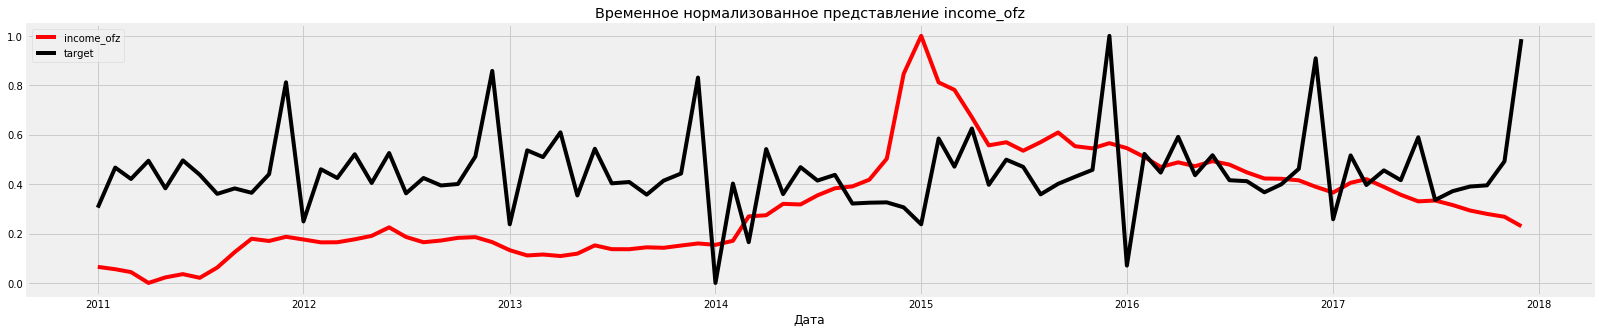

In [386]:
show_feature_intime(BASE_features[0])

Описание поведения признака income_ofz: 
* Начинается в околонулевой области
* До 2012 наблюдается плавный рост
* До 2014 наблюдается стагнация
* К началу 2015 наблюдается  резкий рост до 1
* К середине 2015 наблюдается резкий спад
* После 2015 наблюдается плавное падение к 0 
* На изменения целевой переменной практически не реагирует

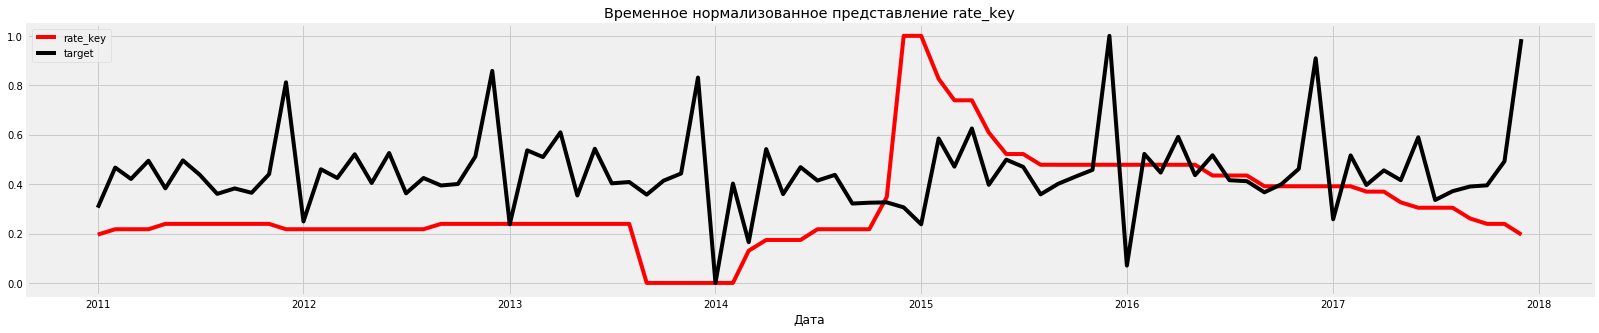

In [387]:
show_feature_intime(BASE_features[1])

Описание поведения признака rate_key: 
* Начинается в области 0.2
* До середины 2013 наблюдается стагнация
* С середины 2013 провал в 0 до начала 2014
* К 2015 наблюдается резкий рост до 1
* К середине 2015 наблюдается резкий спад до 0.5, затем наблюдается плавное падение к 0 
* До 2014 реагирует на провалы целевой переменной, затем до середины 2015 слабо коррелирует, после середины 2015 есть некоторое сходство с трендом целевой переменной

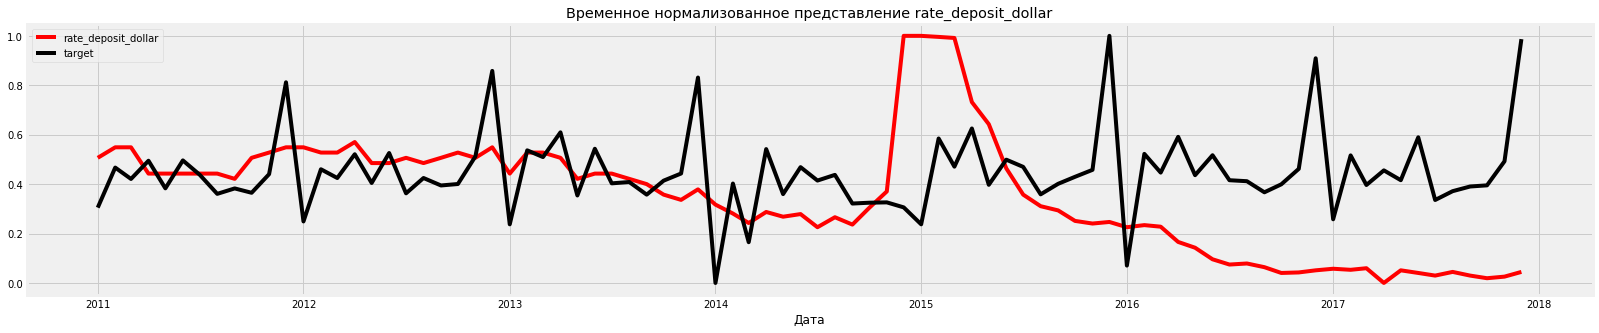

In [388]:
show_feature_intime(BASE_features[2])

Описание поведения признака rate_deposit_dollar: 
* Начинается в области 0.5
* До середины 2014 повторяет общий тренд целевой переменной, затем почти не коррелирует
* С середины 2014 наблюдается  резкий всплеск до 1
* К середине 2015 наблюдается резкий спад
* После 2015 наблюдается плавное падение к 0 

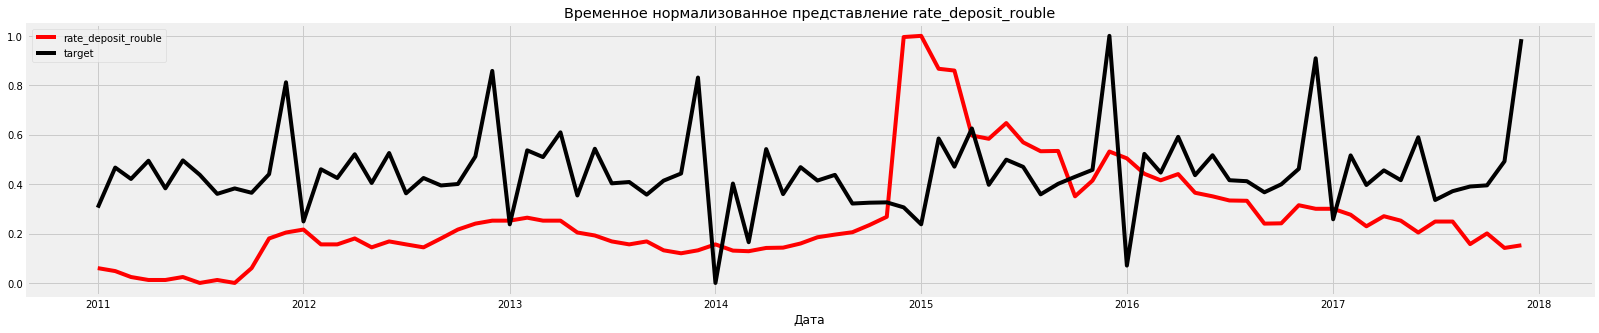

In [389]:
show_feature_intime(BASE_features[3])

Описание поведения признака rate_deposit_rouble: 
* Начинается в околонулевой области
* До конца 2014 наблюдается плавный рост с небольшими скачками и плавным проседанием к началу 2014
* К началу 2015 наблюдается  резкий всплеск до 1
* К середине 2015 наблюдается резкий спад
* После 2015 наблюдается плавное падение к 0 
* С целевой переменной почти не коррелирует

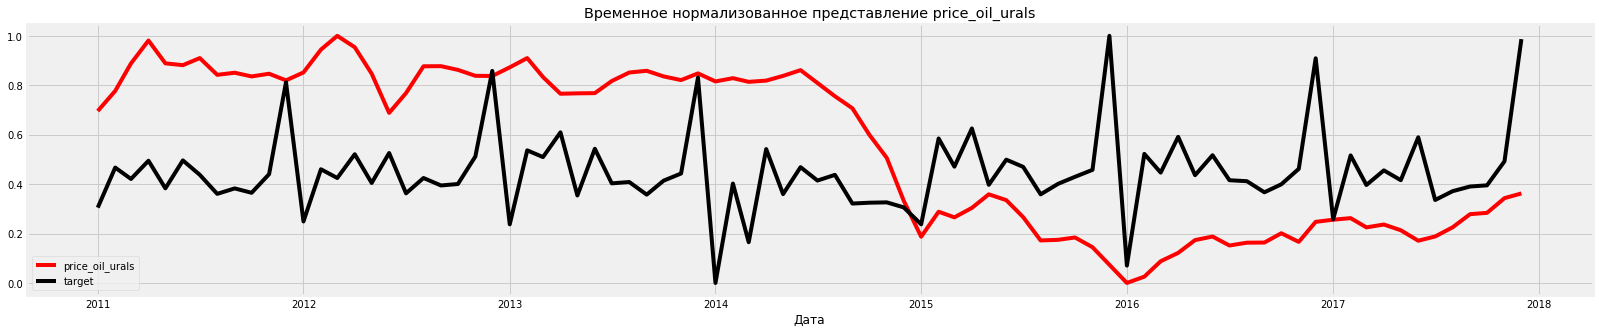

In [390]:
show_feature_intime(BASE_features[4])

Описание поведения признака price_oil_urals: 
* Начинается в области 0.7
* До середины 2014 наблюдается стагнация с хаотичными всплесками и провалами
* На начало 2015 реагирует резким падением
* К 2016 наблюдается спад до 0
* После 2016 года наблюдается плавный рост
* С целевой переменной почти не коррелирует

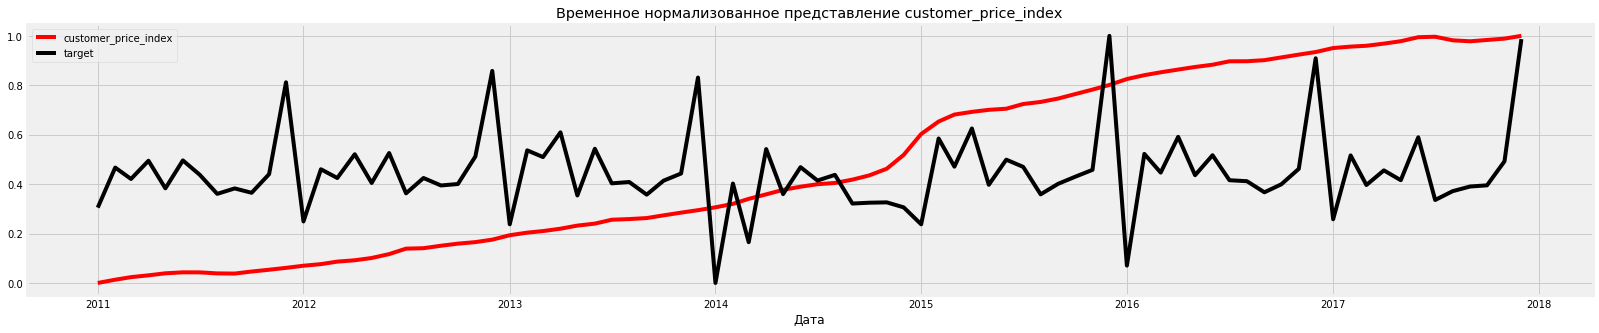

In [391]:
show_feature_intime(BASE_features[5])

Описание поведения признака customer_price_index: 
* Начинается в околонулевой области
* Наблюдается плавный рост во времени до 1, с легким подъемом к 2015
* С целевой переменной не коррелирует

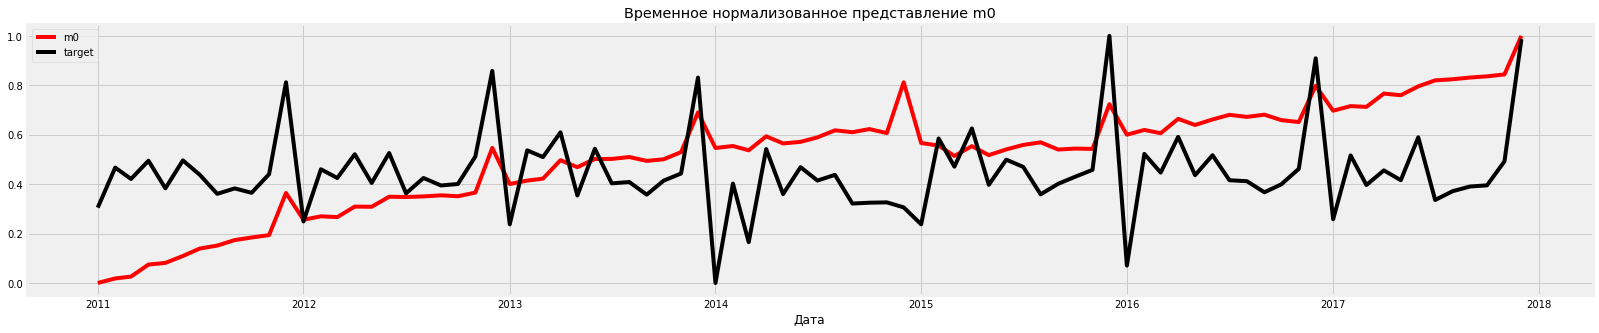

In [392]:
show_feature_intime(BASE_features[6])

Описание поведения признака m0: 
* Начинается в околонулевой области и плавно стремится к 1
* На события 2015 почти не реагирует
* Имеет умеренно выраженную сезонность
* Отлично повторяет новогодние всплески целевой переменной (кроме 2015). Может быть полезен

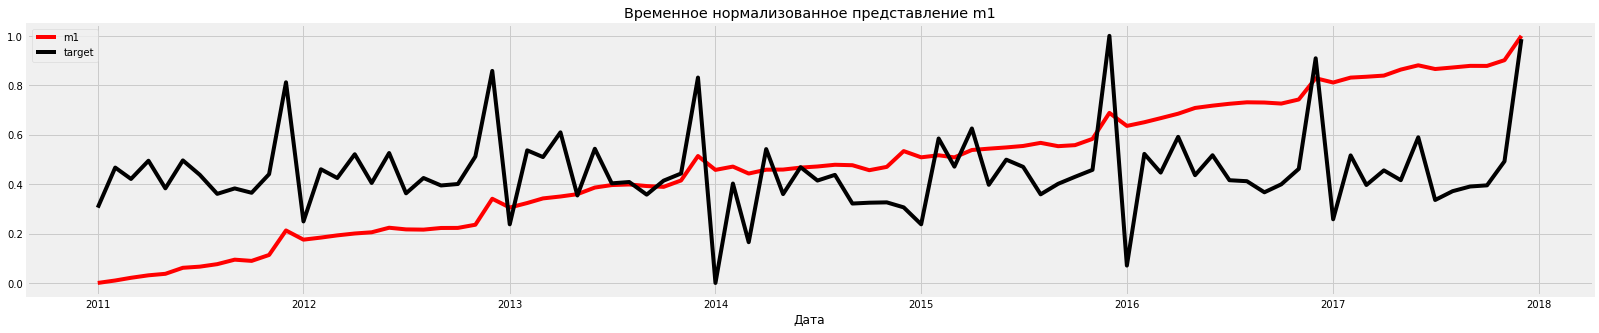

In [393]:
show_feature_intime(BASE_features[7])

Описание поведения признака m1: 
* Начинается в околонулевой области и плавно стремится к 1
* На события 2015 не реагирует
* Имеет слабо выраженную сезонность
* Умеренно повторяет новогодние всплески целевой переменной (кроме 2015). Может быть полезен

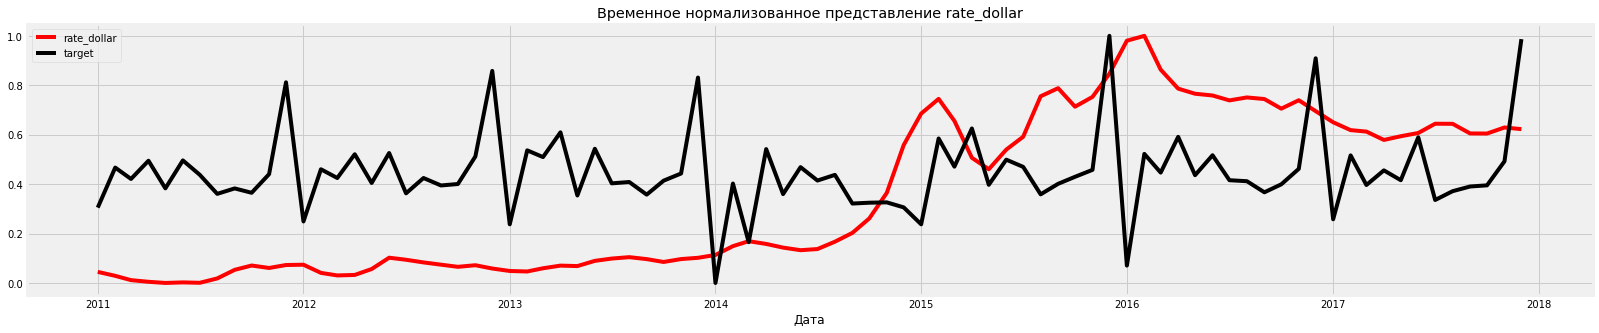

In [394]:
show_feature_intime(BASE_features[8])

Описание поведения признака rate_dollar: 
* Начинается в околонулевой области
* До 2014 наблюдается стагнация
* К началу 2015 наблюдается  резкий всплеск до 0.8
* К середине 2015 наблюдается резкий спад до 0.5
* К началу 2016 наблюдается  резкий всплеск до 1
* После 2016 наблюдается плавное падение к 0.6 и затем стагнация 
* С целевой переменной почти не коррелирует

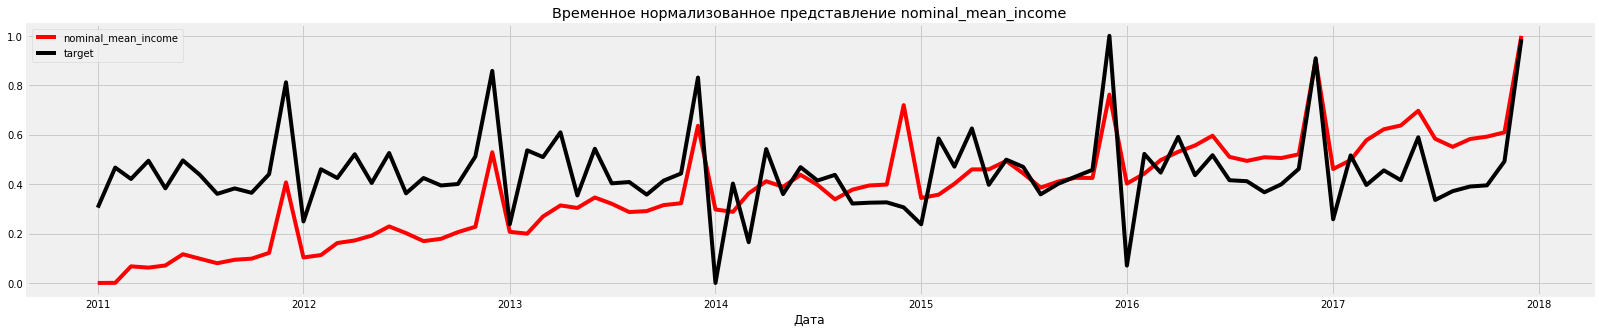

In [395]:
show_feature_intime(BASE_features[9])

Описание поведения признака nominal_mean_income: 
* Начинается в околонулевой области и плавно стремится к 1
* На события 2015 не реагирует
* Отлично повторяет новогодние всплески целевой переменной (кроме 2015)
* Отлично повторяет малые всплески в начале каждого года у целевой переменной
* Имеет ярко выраженную сезонность
* Общий тренд к 2014 сливается с трендом целевой переменной
* Самый полезный признак

__Описание поведения целевой переменной:__
* Целевая переменная имеет общий тренд в районе 0.5
* Имеет ярко-выраженную сезонность: резкие всплески в декабре, резкий спад в январе, затем менее выраженные ежемесячные подъем-спад-подъем-спад-подъем до июня, затем плавную яму до ноября
* На события 2015 реагирует тем, что не имеет всплеска в декабре и менее выраженный спад в январе.

### Дополнительные признаки

Для построения хорошей модели трех полезных признаков может быть недостаточно. Добавим в исходный датасет дополнительные статистические данные из открытых источников по тематике, схожей с полезными признаками:

1. Потребительские вклады
        https://www.cbr.ru/vfs/statistics/pdko/int_rat/deposits.xlsx
2. Показатели денежной массы
        https://www.cbr.ru/vfs/statistics/credit_statistics/M2-M2_SA.xlsx
        https://www.cbr.ru/vfs/statistics/credit_statistics/broadmoney_sa.xlsx
        https://www.cbr.ru/vfs/statistics/ms/mb_bd.xlsx

Данных немного, поэтому добавим их вручную в исходную таблицу .xlsx

In [250]:
df = pd.read_excel(f'{workdir}/BST_DataSet_extended.xlsx')
df.head(3)

Unnamed: 0  Прирост вкладов физических лиц в рублях (млн руб)  \
0 2011-01-01                                           -79049.0   
1 2011-02-01                                           180475.0   
2 2011-03-01                                           106845.0   

   Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
0                           5.244667             7.75   
1                           5.144211             8.00   
2                           5.021364             8.00   

   Ставка по вкладам в долларах до 1 года  \
0                                     2.9   
1                                     3.1   
2                                     3.1   

   Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
0                                   4.5                          96.29   
1                                   4.4                         103.96   
2                                   4.2                         114.44   

   Индекс потребительских цен, ед.    М0, руб  М2, руб  ...  \
0                        106.17151  5532900.0  19307.7  ...   
1                        106.99964  5613700.0  19536.7  ...   
2                        107.66304  5647000.0  19788.7  ...   

   до 30 дней, кроме «до востре-\nбования»  от 31 до 90 дней  \
0                                      3.3               4.0   
1                                      3.2               4.2   
2                                      3.6               3.9   

   от 91 до 180 дней  от 181 дня до 1 года  \
0                5.2                   6.3   
1                5.5                   6.3   
2                4.8                   6.3   

   до 1 года, включая «до востре-\nбования»  \
0                                       4.5   
1                                       4.4   
2                                       4.2   

   до 1 года, кроме «до востре-\nбования»  свыше 1 года  BROAD_MONEY  \
0                                     5.4           5.6      23820.7   
1                                     5.3           5.6      23181.4   
2                                     5.2           5.5      23535.2   

   BROAD_MONEY_SA   \
0     22771.011427   
1     22952.954292   
2     23351.282004   

   наличные деньги в обращении с учетом остатков средств в кассах кредитных организаций1  
0                                             5785.2                                      
1                                             5403.1                                      
2                                             5479.9                                      

[3 rows x 27 columns]

Снова переименуем столбцы для удобства. Старые наименования столбцов:

    Прирост вкладов физических лиц в рублях (млн руб)	
    Доходность ОФЗ по сроку до 1 года	
    Ключевая ставка	
    Ставка по вкладам в долларах до 1 года	
    Ставка по вкладам в рублях до 1 года	
    Нефть марки Юралс, долл./барр	
    Индекс потребительских цен, ед.	
    М0, руб	
    М2, руб	
    Курс доллара к рублю, руб	
    Номинальная средняя з/п, руб	
    
    депозиты банков в Банке России	
    М2	
    М2_SA 	
    «до востре- бования»	
    до 30 дней, включая «до востре- бования»	
    до 30 дней, кроме «до востре- бования»	
    от 31 до 90 дней	
    от 91 до 180 дней	
    от 181 дня до 1 года	
    до 1 года, включая «до востре- бования»	
    до 1 года, кроме «до востре- бования»	
    свыше 1 года
    BROAD_MONEY	
    BROAD_MONEY_SA	
    наличные деньги в обращении с учетом остатков средств в кассах кредитных организаций1

In [251]:
df.columns=[
    'date',
    'target',
    'income_ofz', 
    'rate_key',
    'rate_deposit_dollar',
    'rate_deposit_rouble', 
    'price_oil_urals',
    'customer_price_index', 
    'm0', 
    'm1',
    'rate_dollar', 
    'nominal_mean_income',

    'bank_deposits',
    'm2',
    'm2_sa',
    'deprate_poste_restante',
    'deprate_30d_pr_incl',
    'deprate_30d_pr_excl',
    'deprate_90d',
    'deprate_180d',
    'deprate_1y',
    'deprate_1y_pr_incl',
    'deprate_1y_pr_excl',
    'deprate_1y_more',
    'broad_money',
    'broad_money_sa',
    'cash_in_use',
            ]

In [252]:
df.date = pd.to_datetime(df.date)
df.set_index(df.date, inplace=True)
df.drop(columns=['date'], inplace=True)

In [253]:
BASE_features = df.drop(columns=['target']).columns

### Генерация новых признаков

Имеющихся в наличии базовых и дополнительных признаков все еще может быть недостаточно для построения качественной предсказательной модели. Требуется генерация новых признаков.

In [254]:
for i in range(1, 13):
    df.loc[pd.to_datetime('2018-{:02d}-01'.format(i))] = None

__Предположение 1.__ 

Целевая переменная представляет собой прирост, а не абсолютное значение. Рассчитаем прирост для каждой переменной (с лагом 12) и проверим корреляцию с target.

In [255]:
def features_generator_changevalue(X, features, lag=12):
    for colname in features:
        X[f'NEW_{colname}_changevalue_lag{lag}'] = X[colname].shift(lag) - X[colname].shift(lag+1)
    return X

In [256]:
features_generator_changevalue(df, BASE_features)
df_corr = pd.DataFrame(abs(df.corr()['target']).sort_values(ascending=False))
df_corr[df_corr.target>=THRESHOLD]

target
target                                        1.000000
NEW_m0_changevalue_lag12                      0.801324
NEW_nominal_mean_income_changevalue_lag12     0.778853
NEW_m1_changevalue_lag12                      0.716958
NEW_cash_in_use_changevalue_lag12             0.464214
nominal_mean_income                           0.422435
NEW_deprate_1y_pr_excl_changevalue_lag12      0.385624
NEW_deprate_1y_changevalue_lag12              0.381647
NEW_rate_deposit_dollar_changevalue_lag12     0.370445
NEW_rate_deposit_rouble_changevalue_lag12     0.369666
NEW_deprate_1y_pr_incl_changevalue_lag12      0.369666
NEW_deprate_poste_restante_changevalue_lag12  0.364263
NEW_m2_changevalue_lag12                      0.362970
NEW_rate_key_changevalue_lag12                0.340364
NEW_deprate_90d_changevalue_lag12             0.332291
NEW_deprate_180d_changevalue_lag12            0.331413
NEW_deprate_1y_more_changevalue_lag12         0.301452

__Предположение 2.__ 

Из графиков видно, что как минимум три базовых признака могут быть полезны. Рассчитаем для каждой временной метки значения признаков с лагом 12.

In [257]:
def features_generator_shiftvalue(X, features, lag=12):
    for colname in features:
        X[f'NEW_{colname}_value_lag{lag}'] = X[colname].shift(lag)
    return X

In [258]:
features_generator_shiftvalue(df, BASE_features)
df_corr = pd.DataFrame(abs(df.corr()['target']).sort_values(ascending=False))
df_corr[df_corr.target>=THRESHOLD]

target
target                                        1.000000
NEW_m0_changevalue_lag12                      0.801324
NEW_nominal_mean_income_changevalue_lag12     0.778853
NEW_m1_changevalue_lag12                      0.716958
NEW_cash_in_use_changevalue_lag12             0.464214
NEW_nominal_mean_income_value_lag12           0.442884
nominal_mean_income                           0.422435
NEW_deprate_1y_pr_excl_changevalue_lag12      0.385624
NEW_deprate_1y_changevalue_lag12              0.381647
NEW_rate_deposit_dollar_changevalue_lag12     0.370445
NEW_rate_deposit_rouble_changevalue_lag12     0.369666
NEW_deprate_1y_pr_incl_changevalue_lag12      0.369666
NEW_deprate_poste_restante_changevalue_lag12  0.364263
NEW_m2_changevalue_lag12                      0.362970
NEW_rate_key_changevalue_lag12                0.340364
NEW_deprate_90d_changevalue_lag12             0.332291
NEW_deprate_180d_changevalue_lag12            0.331413
NEW_deprate_1y_more_changevalue_lag12         0.301452

__Предположение 3.__ 

Рассчитаем для каждой временной метки с лагом 12 тренд изменения: 1 рост, 0 стагнация, -1 падение.

In [259]:
def features_generator_trend(X, features, lag=12):
    for colname in features:
        X[f'NEW_{colname}_trend_lag{lag}'] = X[f'NEW_{colname}_changevalue_lag{lag}']. \
                                    apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
    return X

In [260]:
features_generator_trend(df, BASE_features)
df_corr = pd.DataFrame(abs(df.corr()['target']).sort_values(ascending=False))
df_corr[df_corr.target>=THRESHOLD]

target
target                                        1.000000
NEW_m0_changevalue_lag12                      0.801324
NEW_nominal_mean_income_changevalue_lag12     0.778853
NEW_m1_changevalue_lag12                      0.716958
NEW_cash_in_use_changevalue_lag12             0.464214
NEW_nominal_mean_income_value_lag12           0.442884
nominal_mean_income                           0.422435
NEW_m1_trend_lag12                            0.393374
NEW_deprate_1y_pr_excl_changevalue_lag12      0.385624
NEW_cash_in_use_trend_lag12                   0.383284
NEW_deprate_1y_changevalue_lag12              0.381647
NEW_rate_deposit_dollar_changevalue_lag12     0.370445
NEW_rate_deposit_rouble_changevalue_lag12     0.369666
NEW_deprate_1y_pr_incl_changevalue_lag12      0.369666
NEW_deprate_poste_restante_changevalue_lag12  0.364263
NEW_m2_changevalue_lag12                      0.362970
NEW_nominal_mean_income_trend_lag12           0.355792
NEW_m0_trend_lag12                            0.351525
NEW_rate_key_changevalue_lag12                0.340364
NEW_deprate_90d_changevalue_lag12             0.332291
NEW_deprate_180d_changevalue_lag12            0.331413
NEW_rate_deposit_dollar_trend_lag12           0.318059
NEW_deprate_1y_more_changevalue_lag12         0.301452

### Финальная чистка

Удалим из данных аномалии и выбросы. Из графиков очевидно, что в период с 2014-11-01 по 2015-02-01 большинство признаков содержат нетипичные сведения. С учетом лага -12 требуется вычистить данные за период с 2015-11-01 по 2016-02-01, содержащие в новых признаках сведения из аномальных временных меток.

In [261]:
ids_to_drop = df['2015-11-01':'2016-02-01'].index
df.drop(ids_to_drop, axis=0, inplace=True)

Так как предсказываем "неизвестное" будущее, то удалим из данных базовые признаки, которых нет в "неизвестных" временных метках за 2018 год.

In [262]:
df.drop(columns=BASE_features, inplace=True)

Удалим из данных Nan значения в первых строках, полученные вследствие генерации новых признаков с лагом 12.

In [263]:
ids_to_drop = df['2011-01-01':'2012-01-01'].index
df.drop(ids_to_drop, axis=0, inplace=True)

### Отбор решающих признаков и модели

Используем для отбора модели последовательную валидацию на данных до 2017 года, и проверку на данных за 2017 год. Для кросс-валидации и поиска оптимальных гиперпараметров используем RandomizedGridSearch. Метрика отбора наилучшей модели: MAE.

Используем для отбора решающих признаков корреляцию с target выше LOW_THRESHOLD и корреляцию между признаками ниже HIGH_THRESHOLD. Для этого создадим списки указанных трешхолдов, провалидируем модели для каждой связки трешхолдов из списков и запишем результаты MAE в отдельный список.

Создадим специальные функции для удобства выполнения этих задач.

In [264]:
# Функция для удаления из датасета df признаков, коррелированных c target, по заданному threshold
# Возвращает обновленный датасет df
def drop_correlated_with_target(df, threshold):
    df_corr = pd.DataFrame(abs(df.corr()['target']).sort_values(ascending=False))
    cols_to_drop = df_corr[df_corr.target<THRESHOLD].index

    new_df = df.drop(columns=cols_to_drop)
    new_df.fillna(0, inplace=True)
    return new_df

In [265]:
# Функция для удаления из датасета df сильно коррелированных признаков по заданному threshold
# Возвращает обновленный датасет df
def drop_correlated_features(df, threshold):
    col_corr = set() 
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname]

    return df

В рамках задачи требуется сделать прогноз на "будущий" 2018 год, по которому нет данных. Поэтому, для того, чтобы понять насколько точно предсказывает модель, будем разделять датасет на подвыборки: 
* train - тренировочная до 2017 года
* validate - валидация на 2017 годе
* test - "чистое" предсказание на 2018 год

In [266]:
# Функция для разделения датасета на подвыборки train, validate, test
# Возвращает соответствующие наборы X, y
def split_df(df): 
    X_train = df['2011-01-01':'2016-12-01'].drop(columns='target')
    y_train = df['2011-01-01':'2016-12-01'].target

    X_validate = df['2017-01-01':'2017-12-01'].drop(columns='target')
    y_validate = df['2017-01-01':'2017-12-01'].target

    X_test = df['2018-01-01':'2018-12-01'].drop(columns='target')
    y_test = df['2018-01-01':'2018-12-01'].target

    X_train = data_scaler(X_train)
    X_validate = data_scaler(X_validate)
    X_test = data_scaler(X_test)
    
    return np.array(X_train), np.array(y_train), np.array(X_validate), np.array(y_validate), np.array(X_test), np.array(y_test)

Перед нами стоит классическая задача регрессии, поэтому выбор будем делать из моделей, которые должны хорошо с этим справиться:
* LinearRegression
* Ridge
* Lasso
* LinearSVR
* ElasticNet
* BayesianRidge
* KernelRidge
* DecisionTreeRegressor
* XGBRegressor

In [267]:
# Функция кросс-валидации и подбора гиперпараметров с помощью RandomizedSearchCV
# На вход получает: X, y, выбранную модель, словарь параметров для gridsearch, 
# количество итераций для подбора лучших параметров.
# Выводит статистику и возвращает результат метода fit
# обязательно должен быть объявлен список model_list перед инициализацией функции


def cv_model(estimator, param_dict, X, y, n_iter=1000):
    cv = TimeSeriesSplit().split(X)
    model = RandomizedSearchCV(
                                estimator=estimator,
                                cv=cv,
                                param_distributions=param_dict,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1,
                                n_iter=n_iter,        
                              )
    model.fit(X, y)
#     print(f'Модель {len(mdl_list)}: {mdl_tag}')
#     print('Лучший MAE: {:0.2f}'.format(model.best_score_))
#     print(f'Лучшие параметры:\n {model.best_estimator_}')
#     print('_'*80)
    return model

In [268]:
mdl_tags = [
    'LinearRegression',
    'Ridge',
    'Lasso',
    'LinearSVR',
    'ElasticNet',
    'BayesianRidge',
    'KernelRidge',
    'DecisionTreeRegressor',
    'XGBRegressor',
        
]

estimators = [
    LinearRegression(),
    Ridge(random_state=SEED),
    Lasso(random_state=SEED),
    LinearSVR(random_state=SEED),
    ElasticNet(random_state=SEED),
    BayesianRidge(),
    KernelRidge(),
    DecisionTreeRegressor(random_state=SEED, criterion='mae'),
    XGBRegressor(random_state=SEED, eval_metric='mae', objective='reg:squarederror'),
]

param_dicts = [
    #LinearRegression
    {
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'copy_X':[True, False],
    },
    #Ridge
    {
    'alpha':np.linspace(expon.ppf(1e-9), 50, 100),
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'copy_X':[True, False],
    'max_iter':np.arange(5,100),
    'tol':np.linspace(expon.ppf(1e-9), 0.99, 10),
#     'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    },
    #Lasso
    {
    'alpha':np.linspace(expon.ppf(1e-9), 5, 100),
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'precompute':[True, False],
    'copy_X':[True, False],
    'max_iter':np.arange(5,100),
    'tol':np.linspace(expon.ppf(1e-9), 0.99, 10),
    'warm_start':[True, False],
    'positive':[True, False],
    'selection':['cyclic', 'random'],
    },
    #LinearSVR
    {        
    'tol':np.linspace(expon.ppf(1e-9), 0.99, 10),
    'C':np.arange(1,10),
    'epsilon':np.linspace(expon.ppf(1e-9), 0.99, 100),
    'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'fit_intercept':[True, False],
    'intercept_scaling':np.arange(1,10),
#     'dual':[True, False],
    'max_iter':np.arange(5,100),
    },
    #ElasticNet
    {        
    'alpha':np.linspace(expon.ppf(1e-9), 50, 100),
    'l1_ratio':np.linspace(expon.ppf(1e-9), 0.99, 10),    
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'precompute':[True, False],
    'max_iter':np.arange(5,100),
    'copy_X':[True, False],
    'tol':np.linspace(expon.ppf(1e-9), 0.99, 10),
    'warm_start':[True, False],
    'positive':[True, False],
    'selection':['cyclic', 'random'],
    },
    #BayesianRidge
    {       
    'n_iter':np.arange(1,1000),
    'tol':np.linspace(expon.ppf(1e-6), 0.99, 10),
    'alpha_1':np.linspace(expon.ppf(1e-9), 0.99, 100),
    'alpha_2':np.linspace(expon.ppf(1e-9), 0.99, 100),
    'compute_score':[True, False],    
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'copy_X':[True, False],
    },
    #KernelRidge
    {
    'alpha':np.linspace(expon.ppf(1e-9), 50, 100),
    'degree':np.arange(2,5),
    'kernel':[
#         'additive_chi2', 
#         'chi2', 
        'linear', 
        'poly', 
        'polynomial', 
        'rbf', 
        'laplacian', 
        'sigmoid', 
        'cosine'
    ],
    },
    #DecisionTreeRegressor
    {
    'splitter':['best', 'random'],
    'max_depth':np.arange(1,9),
    'min_samples_split':np.arange(2,5),
    'min_samples_leaf':np.arange(1,9),
    'min_weight_fraction_leaf':np.arange(0, 10)*0.05,
    'max_features':['auto', 'sqrt', 'log2', None],
    },
    #XGBRegressor
    {
    'learning_rate':np.linspace(expon.ppf(1e-9), 0.99, 100),
    'max_depth':np.arange(1,9),
    'min_child_weight':np.arange(1,9),
    'subsample':np.linspace(expon.ppf(1e-9), 0.99, 10),
    'colsample_bytree':np.linspace(expon.ppf(1e-9), 0.99, 10),
    'n_estimators':np.arange(1,1000),
    },
]

In [270]:
# задаем диапазоны трешхолдов
high_thresholds = np.arange(5,10) * 0.1
low_thresholds = np.arange(1,6) * 0.1

# общее количество шагов
total_steps = len(high_thresholds) * len(low_thresholds) * len(estimators)

# задаем начальные значения шага переменной, лучшего МАЕ и списков, в которые будем сохранять данные по модели на каждом шаге
curr_step = 0
best_mae = 0

mdl_list = [] 
mae_list = []
low_threshold_list = []
high_threshold_list = []

print(f'Запуск цикла, всего шагов: {total_steps}\n')

for high_threshold in high_thresholds:
    for low_threshold in low_thresholds:
        
        # выборка решающих признаков по трешхолдам
        curr_df = drop_correlated_with_target(df, low_threshold)
        curr_df = drop_correlated_features(curr_df, high_threshold)

        # выполняем GridSearch только если по разделение по трешхолдам отобрало хотя бы 2 признака
        if (len(curr_df.columns)>2): 
            
            X_train, y_train, X_validate, y_validate, X_test, y_test = split_df(curr_df)
            del curr_df

            for mdl_tag, estimator, param_dict in zip(mdl_tags, estimators, param_dicts):
                curr_step = curr_step + 1        
                curr_model = cv_model(estimator, param_dict, X_train, y_train)
                
                # сохраняем результаты данного шага в списки
                mdl_list.append(curr_model)
                mae_list.append(curr_model.best_score_)
                high_threshold_list.append(high_threshold)
                low_threshold_list.append(low_threshold)
                
                # отображение логов, если достигнут лучший показатель MAE на данном шаге
                if curr_step == 1:
                    best_mae = curr_model.best_score_
                if(curr_model.best_score_ > best_mae):
                    best_mae = curr_model.best_score_
                    print('Лучший MAE достигнут на шаге: {:03d}/{}| HGH_THR:{:0.2f}| LOW_THR:{:0.2f}| MAE:{:0.0f} | MDL:{}'.format(
                            curr_step,
                            total_steps,
                            high_threshold, 
                            low_threshold, 
                            curr_model.best_score_,
                            mdl_tag))

print('\nЦикл завершен')


Запуск цикла, всего шагов: 225

Лучший MAE достигнут на шаге: 002/225| HGH_THR:0.50| LOW_THR:0.10| MAE:-143805 | MDL:Ridge
Лучший MAE достигнут на шаге: 004/225| HGH_THR:0.50| LOW_THR:0.10| MAE:-142095 | MDL:LinearSVR
Лучший MAE достигнут на шаге: 016/225| HGH_THR:0.50| LOW_THR:0.20| MAE:-141096 | MDL:KernelRidge
Лучший MAE достигнут на шаге: 035/225| HGH_THR:0.50| LOW_THR:0.40| MAE:-138189 | MDL:DecisionTreeRegressor
Лучший MAE достигнут на шаге: 092/225| HGH_THR:0.70| LOW_THR:0.10| MAE:-137485 | MDL:Ridge
Лучший MAE достигнут на шаге: 094/225| HGH_THR:0.70| LOW_THR:0.10| MAE:-127728 | MDL:LinearSVR
Лучший MAE достигнут на шаге: 098/225| HGH_THR:0.70| LOW_THR:0.10| MAE:-120124 | MDL:DecisionTreeRegressor

Цикл завершен


In [312]:
best_index = np.argmax(mae_list)
best_mdl = mdl_list[best_index]
best_mae = mae_list[best_index]
best_hgh_thr = high_threshold_list[best_index]
best_low_thr = low_threshold_list[best_index]

print(f'Лучшая модель:\n {best_mdl}')
print(f'Ее индекс: {best_index}')
print('Лучший high threshold для отбора признаков: {:0.2f}'.format(best_hgh_thr))
print('Лучший low threshold для отбора признаков: {:0.2f}'.format(best_low_thr))
print('MAE модели: {:0.2f}'.format(best_mae))

Лучшая модель:
 RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000000018B6F2C8>,
                   error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mae',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   rand...
                                        'max_features': ['auto', '

Посмотрим на важность признаков в лучшей модели.

In [313]:
curr_df = drop_correlated_with_target(df, best_low_thr)
curr_df = drop_correlated_features(curr_df, best_hgh_thr)
df_fi = pd.DataFrame({"feature_importance":best_mdl.best_estimator_.feature_importances_}, index=curr_df.drop(columns='target').columns)
df_fi

feature_importance
NEW_m0_changevalue_lag12                       0.635850
NEW_m2_changevalue_lag12                       0.346701
NEW_nominal_mean_income_value_lag12            0.000000
NEW_rate_deposit_dollar_trend_lag12            0.000000
NEW_m0_trend_lag12                             0.000000
NEW_m1_trend_lag12                             0.000000
NEW_nominal_mean_income_trend_lag12            0.000000
NEW_cash_in_use_trend_lag12                    0.017449

Из отчета следует, что возможна дальнейшая оптимизация. Для этого уберем из датасета все зануленные признаки, и прогоним fit еще раз, но уже с большим количеством итераций.

In [314]:
best_features = list(df_fi[df_fi.feature_importance!=0].index)
best_features.append('target')
best_features

['NEW_m0_changevalue_lag12',
 'NEW_m2_changevalue_lag12',
 'NEW_cash_in_use_trend_lag12',
 'target']

In [333]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split_df(df[best_features])
estimator = DecisionTreeRegressor(random_state=SEED, criterion='mae')
param_dict =     {
    'splitter':['best', 'random'],
    'max_depth':np.arange(1,9),
    'min_samples_split':np.arange(2,5),
    'min_samples_leaf':np.arange(1,9),
    'min_weight_fraction_leaf':np.arange(0, 10)*0.05,
    'max_features':['auto', 'sqrt', 'log2', None],
    }
val_model = cv_model(estimator, param_dict, X_train, y_train, 50000)

In [376]:
val_mae = val_model.best_score_
print('MAE модели: {:0.2f}'.format(val_mae))
val_model.best_estimator_

MAE модели: -119129.83


DecisionTreeRegressor(criterion='mae', max_depth=4, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='random')

Вывод: показатель MAE улучшился после данной оптимизации.

### Валидация

Валидация модели будет выполняться на данных 2017 года.

In [337]:
y_pred = val_model.predict(X_validate)

Выведем сравнительный график предсказанных и истинных значений.

In [345]:
def show_predict_intime(y_pred, y_test, mae):
    labels = ['predict', 'target']
    plt.figure(figsize=(25,5))
    plt.plot(y_pred, c='red')
    plt.plot(y_test, c='black')
    plt.legend(labels)
    plt.title('График сравнения предсказания с целевой переменной. MAE: {:.2f}'.format(mae))
    plt.show()

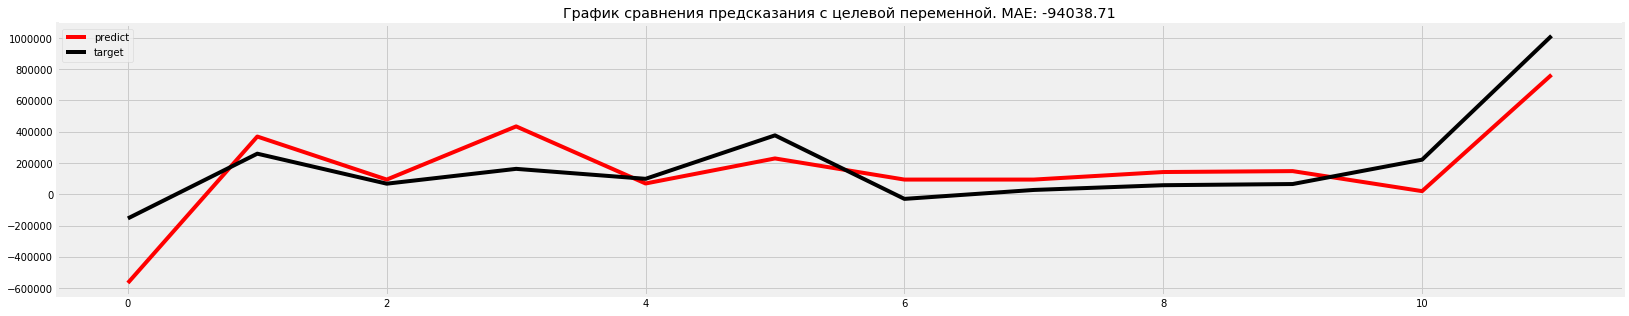

In [346]:
show_predict_intime(y_pred, np.asarray(y_validate), val_mae)

Посмотрим на ошибку MAE в 2017.

In [338]:
df_stats = pd.DataFrame({
        'Прогноз млн. руб.': np.round(y_pred, 2),
        'Реальные данные, млн. руб.': np.round(y_validate, 2),
        'Разница, млн. руб. (MAE)': np.round(abs(y_pred - y_validate), 2),
})
df_stats

Прогноз млн. руб.  Реальные данные, млн. руб.  Разница, млн. руб. (MAE)
0           -567448.0                  -154550.00                 412898.00
1            369176.0                   259531.00                 109645.00
2             93908.0                    67600.00                  26308.00
3            434065.0                   162438.00                 271627.00
4             68827.0                    98717.00                  29890.00
5            229048.0                   376709.30                 147661.30
6             93908.0                   -29642.93                 123550.93
7             93908.0                    27503.93                  66404.07
8            142125.0                    57844.70                  84280.30
9            147971.0                    65361.35                  82609.65
10            19881.5                   221113.78                 201232.28
11           764180.0                  1013335.87                 249155.87

In [353]:
print('Максимальный MAE в 2017: {:.2f}'.format(abs(y_pred - y_validate).max()))
print('Средний MAE без максимального значения: {:.2f}'.format(np.mean(abs(y_pred - y_validate)[1:])))

Максимальный MAE в 2017: 412898.00
Средний MAE без максимального значения: 126578.58


__Решение:__ данную модель используем для предсказания 2018

__Выводы:__ 
* Выбранная модель дает предсказание для 2017 на 12 временных меток в будущее со средней разницей в 94038.71 млн. руб. Максимальная разница имеется в январе и составляет 412898.00 млн. руб. - очень высокая. Это означает, что модель ошибается на аномальных месяцах (начало января - длинные выходные). Без данного значения МАЕ в 2017 составляет 126578.58 млн. руб.
* Использование данных за более короткие интервалы времени, например еженедельные, должно существенно уменьшить ошибку.
* Модель показывает хорошее сходство с трендом целевой переменной.
* Для дальнейшего улучшения качества модели необходимо получить дополнительные данные, связанные с сезонной покупательской активностью населения. Они наилучшим образом должны коррелировать с целевой переменной.
* Для дальнейшего улучшения качества модели необходимо получить дополнительные экономические показатели, схожие с M0 и M2.

### Предсказание на 2018

С увеличением числа тренировочной выборки должна увеличиться точность модели. Поэтому выполним обучение модели заново на данных по 2017-й год включительно, на тех же параметрах.

In [358]:
X_train = np.vstack((X_train, X_validate))

In [365]:
y_train = np.hstack((y_train, y_validate))

In [377]:
final_model = DecisionTreeRegressor(criterion='mae', max_depth=4, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='random')
final_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=4, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='random')

In [380]:
y_pred = final_model.predict(X_test)

Выведем результаты финального предсказания в табличном и графическом форматах

In [382]:
result = pd.DataFrame({'Дата':df[-12:].index, 
                       'Прирост вкладов физических лиц в рублях (млн руб)':y_pred})
result

Дата  Прирост вкладов физических лиц в рублях (млн руб)
0  2018-01-01                                        -360999.000
1  2018-02-01                                         145048.000
2  2018-03-01                                           5070.000
3  2018-04-01                                         376709.297
4  2018-05-01                                           5070.000
5  2018-06-01                                         145048.000
6  2018-07-01                                          77441.000
7  2018-08-01                                           5070.000
8  2018-09-01                                           5070.000
9  2018-10-01                                           5070.000
10 2018-11-01                                         145048.000
11 2018-12-01                                        1013335.870

In [383]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result['Дата'],
    y=result['Прирост вкладов физических лиц в рублях (млн руб)'],
    name="Прирост вкладов физических лиц в рублях (млн руб)"    
))

fig.update_layout(
    title="Прогноз прироста вкладов физических лиц в рублях (млн руб) за 2018",
    xaxis_title="Дата",
    yaxis_title="Прирост вкладов физических лиц в рублях (млн руб)",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="#7f7f7f"
    )
)

fig.show()